# Sentiment Analysis of Tweets about Coronavirus

Priscila Marques de Oliveira

Base retirada de: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

Baseado no código de: https://www.kaggle.com/code/edgardjonathan/bert-deep-learning

## Imports

In [1]:
#!pip install emoji

In [1]:
#from typing import Tuple
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re, string
import emoji
import nltk

## Load Dataset

In [2]:
ds_tweets_train = pd.read_csv('./Corona_NLP_train.csv')

FileNotFoundError: [Errno 2] No such file or directory: './Corona_NLP_train.csv'

In [ ]:
ds_tweets_test = pd.read_csv('./Corona_NLP_test.csv')

In [5]:
ds_tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
ds_tweets_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


## Data Cleaning

In [7]:
ds_tweets_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
ds_tweets_train.duplicated().any()

False

In [9]:
ds_tweets_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

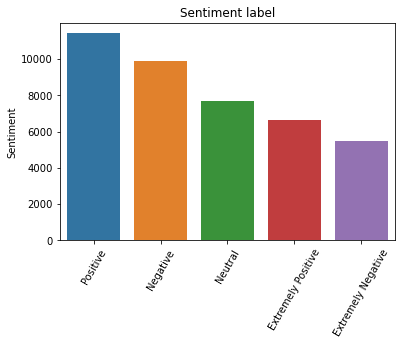

In [10]:
sns.barplot(x = ds_tweets_train['Sentiment'].value_counts().index, 
            y = ds_tweets_train['Sentiment'].value_counts()).set_title('Sentiment label')
plt.xticks(rotation = 60);

Changing the target in string to numbers

In [11]:
ds_tweets_train['Sentiment'] = ds_tweets_train['Sentiment'].map(\
             {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
ds_tweets_test['Sentiment'] = ds_tweets_test['Sentiment'].map(\
            {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

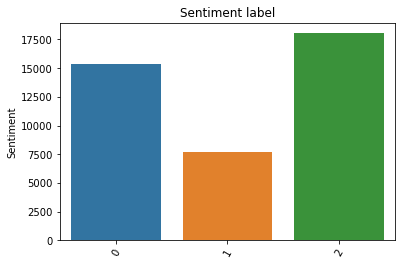

In [12]:
sns.barplot(x = ds_tweets_train['Sentiment'].value_counts().index, 
            y = ds_tweets_train['Sentiment'].value_counts()).set_title('Sentiment label')
plt.xticks(rotation = 60);

In [13]:
def get_top_data(top_n = 5000):
    ds_tweets_train_positive = ds_tweets_train[ds_tweets_train['Sentiment'] == 2].head(top_n)
    ds_tweets_train_negative = ds_tweets_train[ds_tweets_train['Sentiment'] == 0].head(top_n)
    ds_tweets_train_neutral = ds_tweets_train[ds_tweets_train['Sentiment'] == 1].head(top_n)
    ds_tweets_train_small = pd.concat([ds_tweets_train_positive, ds_tweets_train_negative, ds_tweets_train_neutral])
    return ds_tweets_train_small

# Function call to get the top 7500 from each sentiment
ds_tweets_train = get_top_data(top_n=7500)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(ds_tweets_train['Sentiment'].value_counts())
ds_tweets_train.head(10)

After segregating and taking equal number of rows for each sentiment:
0    7500
1    7500
2    7500
Name: Sentiment, dtype: int64


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,2
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,2
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,2
11,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",2
12,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. Lets ALL l...,2
13,3812,48764,"Chicago, IL",16-03-2020,"Me: I don't need to stock up on food, I'll jus...",2
14,3813,48765,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,2


In [14]:
ds_tweets_train.head(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,2
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,2
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,2
11,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",2
12,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. Lets ALL l...,2
13,3812,48764,"Chicago, IL",16-03-2020,"Me: I don't need to stock up on food, I'll jus...",2
14,3813,48765,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,2


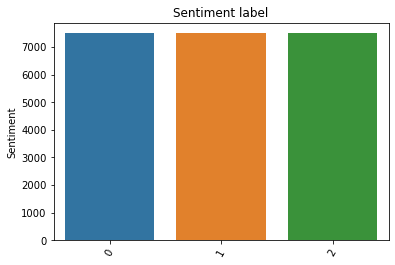

In [15]:
sns.barplot(x = ds_tweets_train['Sentiment'].value_counts().index, 
            y = ds_tweets_train['Sentiment'].value_counts()).set_title('Sentiment label')
plt.xticks(rotation = 60);

### The null values will not be deleted because we don't need them. Only tweet and sentimet

In [16]:
ds_tweets_train = ds_tweets_train[['OriginalTweet','Sentiment']]
ds_tweets_test = ds_tweets_test[['OriginalTweet','Sentiment']]

In [17]:
ds_tweets_train.head()

,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia: Woolworths to give elde...,2
3,My food stock is not the only one which is emp...,2
5,As news of the regions first confirmed COVID-...,2
6,Cashier at grocery store was sharing his insig...,2


In [18]:
ds_tweets_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
1,When I couldn't find hand sanitizer at Fred Me...,2
2,Find out how you can protect yourself and love...,2
3,#Panic buying hits #NewYork City as anxious sh...,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1


https://www.tensorflow.org/text/tutorials/classify_text_with_bert

### Clean Tweets

Using regex remove numbers, special characters, retweets, url and pontuation

In [19]:
def cleaning_tweets(tweet):
    # remove links
    tweet = "".join(re.sub("(\w+:\/\/\S+)"," ", tweet))
    
    # remove hashtags
    tweet = "".join(re.sub("(#[A-Za-z0-9_]+)"," ", tweet))
    
    # remove user mention
    tweet = "".join(re.sub("(@[A-Za-z0-9_]+)"," ", tweet))
    
    # remove none alphanumeric and aposthrope
    tweet = "".join(re.sub("([^0-9A-Za-z \t'])"," ", tweet))
    
    # remove extra whitespace
    tweet = " ".join(tweet.split())
    
    # remove emoji unicode 
    tweet = "".join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    
    # remove leading and trailing space
    tweet = tweet.strip()
    return tweet

In [20]:
ds_tweets_train['OriginalTweet'] = ds_tweets_train['OriginalTweet'].apply(lambda x: cleaning_tweets(x))
ds_tweets_test['OriginalTweet'] = ds_tweets_test['OriginalTweet'].apply(lambda x: cleaning_tweets(x))

In [21]:
ds_tweets_train.head()

,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia Woolworths to give elder...,2
3,My food stock is not the only one which is emp...,2
5,As news of the region s first confirmed COVID ...,2
6,Cashier at grocery store was sharing his insig...,2


Removing tweets with less them five words, because theses kind of tweets will not have any useful information

In [22]:
ds_tweets_train = ds_tweets_train[ds_tweets_train['OriginalTweet'].apply(lambda x: len(x.split()) > 5)]
ds_tweets_test = ds_tweets_test[ds_tweets_test['OriginalTweet'].apply(lambda x: len(x.split()) > 5)]

In [23]:
ds_tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21854 entries, 1 to 40106
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  21854 non-null  object
 1   Sentiment      21854 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 512.2+ KB


In [24]:
ds_tweets_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3755 non-null   object
 1   Sentiment      3755 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 88.0+ KB


In [25]:
ds_tweets_train['OriginalTweet'].str.len().max()

287

## Training Bert

Divide training dataset in training and validation

In [26]:
x_train = ds_tweets_train['OriginalTweet']
y_train = ds_tweets_train['Sentiment']
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=43)
x_test = ds_tweets_test['OriginalTweet']
y_test = ds_tweets_test['Sentiment']

In [27]:
#!pip install tensorflow
#!pip install transformers

In [28]:
import tensorflow as tf
#tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
from transformers import BertTokenizerFast, TFBertModel
#from transformers import InputExample, InputFeatures

In [29]:
tf.__version__

'2.9.1'

In [30]:
tf.test.is_built_with_cuda()

True

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Using the BERTTokenizer with the pre-trained tokenizer from the model bert-base-uncased

This pre-trained model add:
- [CLS] in front of the string which means start of string
- [SEP] at the end of the string which means the end of the string
- [PAD] this is done if the string length is less than max length given in the input. Because the model only receive input with same length

In [32]:
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [33]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(17483, 3)
(4371, 3)
(3755, 3)


### Tokenization

In [34]:
MAX_LEN=128

def bert_tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for tweet in data:
        encoded = bert_tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [35]:
train_input_ids, train_attention_masks = bert_tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = bert_tokenize(x_valid, MAX_LEN)
test_input_ids, test_attention_masks = bert_tokenize(x_test, MAX_LEN)

### Validation

In [36]:
from tensorflow import keras

In [37]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
def create_model(bert_model, max_len=MAX_LEN):
    
    # parameter
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    bert = bert_model([input_ids,attention_masks])[1]
    dropout = tf.keras.layers.Dropout(0.2)(bert)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(optimizer, loss=loss, metrics=accuracy)
    
    return model

In [39]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

### Train

In [40]:
EPOCHS = 10
BATCH_SIZE = 8
checkpoint_filepath = './BERT'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

train_history = model.fit([train_input_ids,train_attention_masks], 
                          y_train, 
                          validation_data=([val_input_ids,val_attention_masks], y_valid),
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          callbacks=[model_checkpoint_callback])

Epoch 1/10
2186/2186 [==============================] - 448s 201ms/step - loss: 0.5589 - categorical_accuracy: 0.7792 - val_loss: 0.3584 - val_categorical_accuracy: 0.8744
Epoch 2/10
2186/2186 [==============================] - 437s 200ms/step - loss: 0.2735 - categorical_accuracy: 0.9034 - val_loss: 0.4345 - val_categorical_accuracy: 0.8604
Epoch 3/10
2186/2186 [==============================] - 440s 201ms/step - loss: 0.1687 - categorical_accuracy: 0.9413 - val_loss: 0.3781 - val_categorical_accuracy: 0.8874
Epoch 4/10
2186/2186 [==============================] - 438s 200ms/step - loss: 0.1230 - categorical_accuracy: 0.9576 - val_loss: 0.3754 - val_categorical_accuracy: 0.9025
Epoch 5/10
2186/2186 [==============================] - 437s 200ms/step - loss: 0.0889 - categorical_accuracy: 0.9685 - val_loss: 0.3516 - val_categorical_accuracy: 0.8865
Epoch 6/10
2186/2186 [==============================] - 437s 200ms/step - loss: 0.0722 - categorical_accuracy: 0.9762 - val_loss: 0.5125 - v

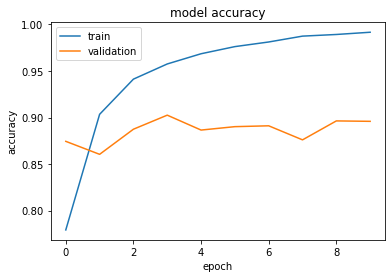

In [41]:
plt.plot(train_history.history['categorical_accuracy'])
plt.plot(train_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

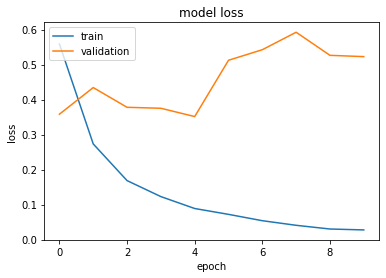

In [42]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test BERT

In [43]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [44]:
y_pred = model.predict([test_input_ids,test_attention_masks])

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

118/118 [==============================] - 26s 202ms/step


Accuracy: 88.18 


Classification Report,
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      1630
     Neutral       0.75      0.85      0.80       587
    Positive       0.91      0.88      0.90      1538

    accuracy                           0.88      3755
   macro avg       0.86      0.88      0.87      3755
weighted avg       0.88      0.88      0.88      3755



Confusion Matrix,


<AxesSubplot:>

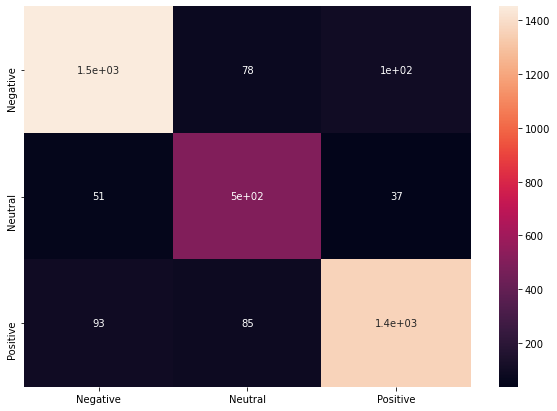

In [45]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

labels = ['Negative', 'Neutral', 'Positive']

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred) 
print("Accuracy: %.2lf " % (accuracy*100))

print()
print()
print("Classification Report,")
print(classification_report(y_test,y_pred, target_names=labels))

print()
print()
print("Confusion Matrix,")
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = pd.DataFrame(cf_matrix, index = labels,
                  columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True)

## Discussion of results